In [48]:
DIR = "byhand/";
ps_kwargs(twofast::Bool) = twofast ?
    Dict(:twofast=>true, :epl => true, :pr => false, 
          :N_left => 12, :N_right => 12,
          :p0_left => [-2.0, 1.0], :p0_right => [-2.0, 1.0],
          :int_s_min => 1e0, :int_s_max => 1200.0) :
    Dict(:twofast=>false, :pr=>true, :ν => 1.5, :n_extrap_low => 0,
     :n_extrap_high => 0, :n_pad => 500, :cut_first_n=>6);
tf = false;

## Basic Framework

In [2]:
PATH_TO_GAPSE = "../";

In [3]:
include(PATH_TO_GAPSE * "src/GaPSE.jl");

In [4]:
using DelimitedFiles, Plots, Dierckx, SpecialFunctions
using Printf, LaTeXStrings, Turing, StatsPlots, GridInterpolations

In [5]:
#z_min, z_max, θ_max = 0.05, 0.20, π / 2.0
z_min, z_max, θ_max = 1.0, 1.5, π / 2.0

WFI_opts = Dict(
    :ss_start => 0.0, :ss_stop => 0.0, 
    :ss_step => 50, :llim => 0.0, :rlim => Inf, 
    :rtol => 5e-2, :atol => 0.0, :N => 1000, #:pr => true,
)

FILE_F_MAP = PATH_TO_GAPSE * "data/F_REFERENCE_pi2.txt"
FILE_PS = PATH_TO_GAPSE * "test/datatest/file_pk.txt"
FILE_BACKGROUND = PATH_TO_GAPSE * "test/datatest/WideA_ZA_background.dat"

params = GaPSE.CosmoParams(z_min, z_max, θ_max;
    Ω_b = 0.0489, Ω_cdm = 0.251020, h_0 = 0.70, s_lim=1e-2,
    s_b = 0.0, 𝑓_evo = 0.0, b = 1.0,
    IPS_opts = Dict(
        :fit_left_min => 1e-6, :fit_left_max => 3e-6,
        :fit_right_min => 1e1, :fit_right_max => 2e1),
    IPSTools_opts = Dict(
        :N => 1024, :fit_min => 0.05, :fit_max => 0.5, 
        :con => true, :k_min => 1e-8, :k_max => 10.0),
    WFI_opts = WFI_opts,
);

In [6]:
#=
new_calc_μs = union([μ for μ in -1.0:0.01:(-0.9)], 
        [μ for μ in -0.9:0.05:0.9], 
        [μ for μ in 0.9:0.01:1.0]);
FILE_IF_MAP = PATH_TO_GAPSE*"data/IntF_pi2_z115.txt"

GaPSE.print_map_IntegratedF(
    FILE_F_MAP, FILE_IF_MAP, 
    z_min, z_max, new_calc_μs, FILE_BACKGROUND;
    trap = true, WFI_opts...
)
=#

In [7]:
FILE_IF_MAP = PATH_TO_GAPSE*"data/IntF_pi2_z115.txt"
cosmo = GaPSE.Cosmology(params, FILE_BACKGROUND, FILE_PS, FILE_F_MAP, FILE_IF_MAP);

GaPSE.parameters_used(stdout, cosmo)

###############
#    GaPSE    #
############### 
#
# The Cosmology considered had the following paremeters:
# 
# - Matter Power Spectrum input file: "../test/datatest/file_pk.txt"
# - Background data input file: "../test/datatest/WideA_ZA_background.dat"
# - F window function input file: "../data/F_REFERENCE_pi2.txt"
# - Integrated F window function input file: "../data/IntF_pi2_z115.txt"
#
# - Basic CosmoParams considered: 
#	 z_min = 1.0 	 z_max = 1.5
#	 θ_max = 1.5707963267948966 [rad] 	 h_0 = 0.7
#	 Ω_b = 0.0489 	 Ω_cdm = 0.25102 	 Ω_M0 = 0.29992
#	 b = 1.0 	 f_evo = 0.0 	 s_b = 0.0
#
# - CosmoParams about the Input Power Spectrum: 
#	 fit_left_min = 1.0e-6 	 fit_right_min = 10.0 	 
#	 fit_left_max = 3.0e-6 	 fit_right_max = 20.0 	 
#
# - CosmoParams about the Input Power Spectrum Tools: 
#	 k_max = 10.0 	 fit_max = 0.5 	 N = 1024 	 
#	 con = true 	 k_min = 1.0e-8 	 fit_min = 0.05 	 
#
# - CosmoParams about the Integrated Window Function F: 
#	 ss_step = 50 	 N = 1000 	 rtol = 0.05

## I00 Enea and mine comparison

In [8]:
enea_ss, enea_I00s = GaPSE.readxy("calc.dat"; comments=false);

In [9]:
my_I00s = [cosmo.tools.I00(s) for s in enea_ss];

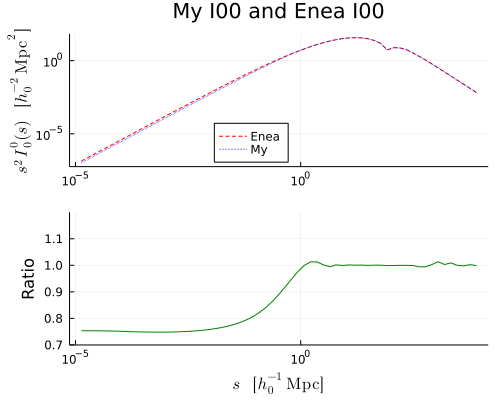

In [21]:
LIM1, LIM2 = 1e-5, 1e4

xs_1 = enea_ss[LIM1 .< enea_ss .< LIM2]
ys_1 = abs.(enea_I00s[LIM1 .< enea_ss .< LIM2] .* xs_1 .^2)

xs_2 = enea_ss[LIM1 .< enea_ss .< LIM2]
ys_2 = abs.(my_I00s[LIM1 .< enea_ss .< LIM2] .* xs_2 .^2)
spline = Spline1D(xs_2, ys_2)

S_VLIM = 8
S_VLIM_F = @sprintf("%.2f", S_VLIM)

p1 = plot([xs_1, xs_2], [ys_1, ys_2],
    xaxis=:log, yaxis=:log, 
    lc=[:red :blue], 
    title = "My I00 and Enea I00",
    label=["Enea" "My"], ls=[:dash :dot], 
    ylabel = L"s^2 \, I_0^0(s) \quad [h_0^{-2} \,\mathrm{Mpc}^{2}]",
    legend=:bottom)
#vline!(p1, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p2 = plot(xs_1, spline.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log,
    ylim=(0.7,1.2), 
    legend=false, 
    xlabel=L"$s \quad [h_0^{-1} \,\mathrm{Mpc}]$")
#vline!(p2, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

P = plot(p1, p2, size=(500, 400), layout= @layout [ x ; z ] )
#savefig(P, "PS_AutoDoppler_L0.pdf")
#display(P)

## Newtonian TPCF and PPMatter TPCF 

In [29]:
GaPSE.print_map_ξ_PPMatter_multipole(cosmo, 
    DIR*"xi_ppmatter_L0_withF.txt", 
    10 .^ range(0,log10(2*cosmo.s_max),length=1000);
    L = 0, use_windows = true, pr = true, enhancer = 1e6,
    μ_atol = 0.0, μ_rtol = 1e-2);

PP Matter, L=0: 100%|███████████████████████████████████| Time: 0:00:07



time needed for map_ξ_PPMatter_multipole [in s] = 7.37223 


In [30]:
GaPSE.print_map_ξ_GNC_multipole(cosmo, 
    DIR*"xi_Newtonian_L0_withF.txt", "auto_newton",
    10 .^ range(0,log10(2*cosmo.s_max),length=1000);
    L = 0, use_windows = true, pr = true, enhancer = 1e6,
    μ_atol = 0.0, μ_rtol = 1e-2);

auto_newton, L=0: 100%|█████████████████████████████████| Time: 0:00:06



time needed for map_ξ_GNC_multipole for auto_newton [in s] = 6.69723 



In [31]:
ss_ppm_L0_withF, xis_ppm_L0_withF = GaPSE.readxy(DIR*"xi_ppmatter_L0_withF.txt");
ss_Newt_L0_withF, xis_Newt_L0_withF = GaPSE.readxy(DIR*"xi_Newtonian_L0_withF.txt");

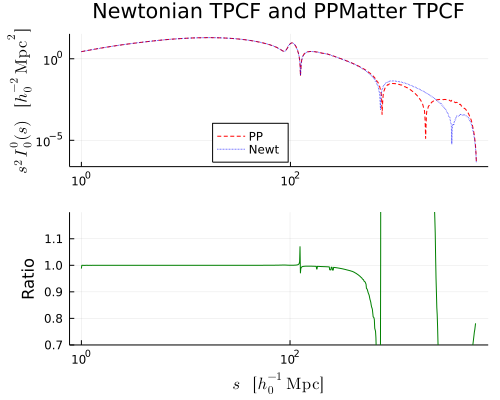

In [34]:
xs_1 = ss_ppm_L0_withF
ys_1 = abs.(xis_ppm_L0_withF .* xs_1 .^2)

xs_2 = ss_Newt_L0_withF
ys_2 = abs.(xis_Newt_L0_withF .* xs_2 .^2)
spline = Spline1D(xs_2, ys_2)

S_VLIM = 8
S_VLIM_F = @sprintf("%.2f", S_VLIM)

p1 = plot([xs_1[ys_1 .≠ 0], xs_2[ys_2 .≠ 0]], [ys_1[ys_1 .≠ 0], ys_2[ys_2 .≠ 0]],
    xaxis=:log, yaxis=:log, 
    lc=[:red :blue], 
    title = "Newtonian TPCF and PPMatter TPCF",
    label=["PP" "Newt"], ls=[:dash :dot], 
    ylabel = L"s^2 \, I_0^0(s) \quad [h_0^{-2} \,\mathrm{Mpc}^{2}]",
    legend=:bottom)
#vline!(p1, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p2 = plot(xs_1, spline.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log,
    ylim=(0.7,1.2), 
    legend=false, 
    xlabel=L"$s \quad [h_0^{-1} \,\mathrm{Mpc}]$")
#vline!(p2, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

P = plot(p1, p2, size=(500, 400), layout= @layout [ x ; z ] )
#savefig(P, "PS_AutoDoppler_L0.pdf")
#display(P)

## Newtonian PS and PPMatter PS

In [41]:
GaPSE.print_PS_multipole(DIR*"xi_ppmatter_L0_withF.txt", 
    DIR*"ps_ppmatter_L0_withF.txt"; L = 0, ps_kwargs(tf)...);


I'm computing the PS_multipole from the file "byhand/xi_ppmatter_L0_withF.txt" 

time needed for this Power Spectrum computation [in s] = 0.006685018539428711



In [49]:
GaPSE.print_PS_multipole(DIR*"xi_Newtonian_L0_withF.txt", 
    DIR*"ps_Newtonian_L0_withF.txt"; L = 0, ps_kwargs(tf)...);


I'm computing the PS_multipole from the file "byhand/xi_Newtonian_L0_withF.txt" 

time needed for this Power Spectrum computation [in s] = 0.002048015594482422



In [50]:
ks_ppm_L0_withF, pks_ppm_L0_withF = GaPSE.readxy(DIR*"ps_ppmatter_L0_withF.txt");
ks_Newt_L0_withF, pks_Newt_L0_withF = GaPSE.readxy(DIR*"ps_Newtonian_L0_withF.txt");

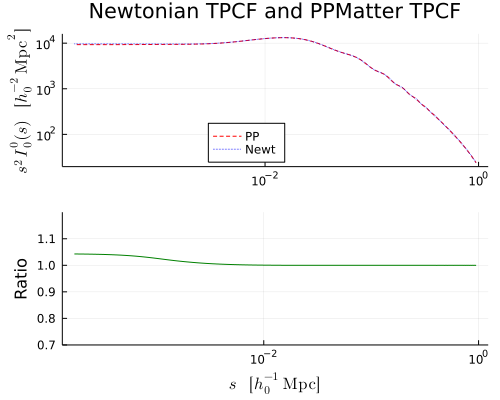

In [51]:
xs_1 = ks_ppm_L0_withF
ys_1 = abs.(pks_ppm_L0_withF)

xs_2 = ks_Newt_L0_withF
ys_2 = abs.(pks_Newt_L0_withF )
spline = Spline1D(xs_2, ys_2)

S_VLIM = 8
S_VLIM_F = @sprintf("%.2f", S_VLIM)

p1 = plot([xs_1[ys_1 .≠ 0], xs_2[ys_2 .≠ 0]], [ys_1[ys_1 .≠ 0], ys_2[ys_2 .≠ 0]],
    xaxis=:log, yaxis=:log, 
    lc=[:red :blue], 
    title = "Newtonian TPCF and PPMatter TPCF",
    label=["PP" "Newt"], ls=[:dash :dot], 
    ylabel = L"s^2 \, I_0^0(s) \quad [h_0^{-2} \,\mathrm{Mpc}^{2}]",
    legend=:bottom)
#vline!(p1, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p2 = plot(xs_1, spline.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log,
    ylim=(0.7,1.2), 
    legend=false, 
    xlabel=L"$s \quad [h_0^{-1} \,\mathrm{Mpc}]$")
#vline!(p2, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

P = plot(p1, p2, size=(500, 400), layout= @layout [ x ; z ] )
#savefig(P, "PS_AutoDoppler_L0.pdf")
#display(P)